# Mark AOIs and find fixations within

## Set up your environment
In the beginning, we load external libraries and define the path to our data.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# larger labels are nicer to read
plt.rcParams.update({'font.size': 18})

# define the path on your own PC
path_to_reference_image_mapper = "./Art-_Gallery_Picture_Viewing_REFERENCE-IMAGE-MAPPER_multiple_paintings_standing_csv"

## Load the reference image and fixations

In [2]:
# load the reference image
reference_image = cv2.imread(f"{path_to_reference_image_mapper}/reference_image.jpeg")
# convert color format to RGB
reference_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)
# import fixation data
fixations = pd.read_csv(f"{path_to_reference_image_mapper}/fixations.csv")

## Marking areas of interest

In the next step, we will mark our areas of interest on the reference image. In this case, we define each image in the picture as an area of interest

In [3]:
# resize the image before labelling aois makes the image stay in the screen boundaries
scaling_factor = 0.25
scaled_image = reference_image.copy()
scaled_image = cv2.resize(scaled_image, 
                             dsize = None, 
                             fx = scaling_factor, 
                             fy = scaling_factor)

Mark the AOIs by clicking in the upper left corner where you want your AOI to start. Than drag the while keeping the mouse pressed until the blue rectangle has the right size. Release the mouse and hit enter or the space bar when you are happy with your selection. If you are not, you can start over by simply marking a new area. 
Repeat this process till you have marked all AOIs needed. Close the selection with the escape key.

In [4]:
scaled_aois = cv2.selectROIs("AOI Annotation", scaled_image);
cv2.destroyAllWindows();

# scale back the position of AOIs
aois = scaled_aois / scaling_factor
print(scaled_aois)

[[134  41 139 129]
 [368 181  88 108]
 [472  84 162 208]
 [650 198 109 137]
 [766 236 107  94]
 [807  67 114 100]
 [222 321 406 208]
 [657 348 210 154]
 [172 624 112 109]
 [309 583  84  84]
 [492 576 142 164]
 [645 516 215 234]]


## Overlaying Areas of Interest on the Reference Image

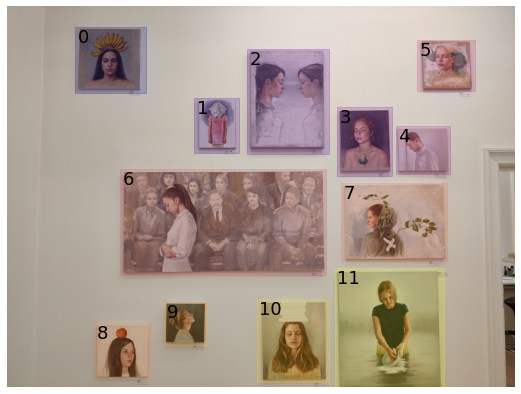

In [5]:
import matplotlib
import matplotlib.patches as patches
aoi_colors = matplotlib.cm.get_cmap('plasma')
n_colorsteps = len(aois) - 1

# List the painting ids as names 
paintings = [idx for idx in range(len(aois))]

# plot the reference image and overlay the AOIS
marked_ref_fig, marked_ref_ax = plt.subplots(1,1, figsize = (10,7))
marked_ref_ax.imshow(np.asarray(reference_image))

def plot_aoi_patches(aois, ax, aoi_colors=aoi_colors, n_colorsteps=n_colorsteps):
    for idx, aoi in enumerate(aois):
        ax.add_patch(patches.Rectangle(aoi, *aoi[2:], alpha=0.2, color = aoi_colors(idx/n_colorsteps)))
        ax.text(aoi[0] + 20, aoi[1] + 120, f"{idx}", color="black")
        
plot_aoi_patches(aois, marked_ref_ax)
marked_ref_ax.set_axis_off()
marked_ref_fig.savefig('./figures/aois_on_reference_image_nested.png')

If you notice after looking at the overlay that some AOIs are not placed correctly, you can manually manipulate the location by changing entries in the aoi array.

## Detecting fixations inside the areas of interest. 

Next up, we want to match the fixation coordinates to the Areas of Interest. This is comparable to asking for every x/y coordinate pair that defines a fixation if that pair is inside any of the rectangles.

In [6]:
def check_in_rect(fixation_data, rectangle_coordinates):
    
    rect_x, rect_y, rect_width, rect_height = rectangle_coordinates
        
    x_hit = fixation_data['fixation x [px]'].between(rect_x, rect_x+rect_width) 
    y_hit = fixation_data['fixation y [px]'].between(rect_y, rect_y+rect_height)
    
    in_rect_idx = x_hit & y_hit
    
    return(in_rect_idx)
        
fixations['AOI'] = None

for aoi_id, aoi in enumerate(aois):
    fixations.loc[check_in_rect(fixations, aoi), 'AOI'] = paintings[aoi_id]

fixations.head()

,section id,recording id,fixation id,start timestamp [ns],end timestamp [ns],duration [ms],fixation detected in reference image,fixation x [px],fixation y [px],AOI
0,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,248,1636035560036503914,1636035560228482914,191,True,2410.0,2134.0,None
1,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,249,1636035560256651914,1636035560476503914,219,True,2224.0,1717.0,6
2,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,250,1636035560500491914,1636035560728557914,228,True,2431.0,1560.0,6
3,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,251,1636035560776494914,1636035560968578914,192,True,1936.0,1118.0,2
4,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,252,1636035561008557914,1636035561148511914,139,True,2826.0,1668.0,7


You can now see the new column "AOI" - this column contains the information if the gaze fell inside a given area of interest. We can viusalize this by plotting the fixations in a different color for each AOI.

In [7]:
def map_colors(idx, length, colors, fallback = [1,1,1,1]):
    """
    This funcion maps the AOI ids to colors, 
    using white as default color for fixations outside an AOI.
    """
    try:
        rgb = colors(idx/length)
    except TypeError:
        rgb = fallback
    return rgb

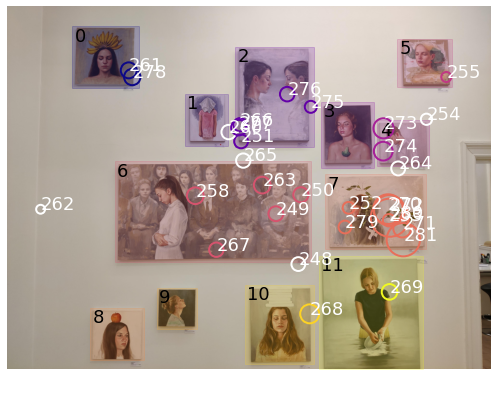

In [11]:
# filter a single subject for easier visualization
example_section = np.unique(fixations['section id'])[0]
example_fixations = fixations[fixations['section id'] == example_section]

aoi_fig, aoi_axs = plt.subplots(1,1, figsize = (10,7))

# show the reference image
aoi_axs.imshow(np.asarray(reference_image))

# plot the aois
plot_aoi_patches(aois, aoi_axs)

# plot fixations at their x- and y-position
aoi_axs.scatter(example_fixations['fixation x [px]'],
                example_fixations['fixation y [px]'],
                # change the face- and edgecolor to get circles rather than dots
                facecolor='none', 
                edgecolor=[map_colors(x, n_colorsteps, aoi_colors) for x in example_fixations.AOI], 
                linewidth=2, 
                # set the size of the circles relative to the duration of each fixation
                s = example_fixations['duration [ms]']);

# ennumerate the fixations
for fix_id, x, y in zip(example_fixations['fixation id'],
                        example_fixations['fixation x [px]'], 
                        example_fixations['fixation y [px]']
                       ):
        aoi_axs.annotate(fix_id, [x, y], color = 'white')
        
aoi_axs.set_axis_off()
aoi_fig.savefig('./figures/aois_fixations_of_reference_image_nested.png');

On this visualization, we can check if the gaze positions were correctly detected inside their AOIs.


## Save the fixation data with AOIs
To process the data further, we export the fixation data frame with AOIs to a new csv file.

In [9]:
fixations.to_csv('fixations_with_aois_nested.csv')